<a href="https://colab.research.google.com/github/moaaz12-web/LayoutLM/blob/main/FineTuning_on_the_SROIE_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning LayoutLM using the SROIE dataset

> Indented block


The model is presented in the paper "[LayoutLM: Pre-training of Text and Layout for Document Image Understanding](https://arxiv.org/abs/1912.13318)" by Yiheng Xu, Minghao Li, Lei Cui, Shaohan Huang, Furu Wei and Ming Zhou and the notebook has been greatly inspired by Github user's"ruifcruz" notebook titled "Fine tune SROIE on LayoutLM".
- LayoutLM Github repo [here](https://github.com/microsoft/unilm/tree/master/layoutlm).
- The dataset was taken from the ICDAR 2019 SROIE competition [here](https://rrc.cvc.uab.es/?ch=13).

## Notes:
- The notebook is using a preprocessing script included in the model's repo [here](https://github.com/microsoft/unilm/tree/master/layoutlm/examples/seq_labeling) which was originally used to fine tune the FUNSD dataset. We can train on the SROIE dataset with the same script because it's meant for sequence labeling.
- The original authors of the model got an F1 score **0.946** (using the base model) and the maximum I got was an F1 score **0.957** (10 epochs). This is an improvement over ruifcruz's score, because I also included the label "company address". It's also an improvement over the authors score and the reason for that, as explained by ruifcruz, could be:
  - Different hyperparameters,
  - For my implementation, I didn't use IOB tagging,
  - quality OCR - the authors didn't use SROIE OCR scans, but created their own,
  - better preprocessing

# 1. Pre-processing the dataset
Before fine-tuning the model, we have to preprocess the SROIE dataset which can be downloaded from [here](https://drive.google.com/drive/folders/1ShItNWXyiY1tFDM5W02bceHuJjyeeJl2). The dataset contains multiple subfolders, because the competition is split up into three tasks **Text Localization, Optical character recognition (OCR)** and **Information Extraction (IE)** and some folders are meant for their specific task. For our purposes we're only interested in the last task, so the folders meant for it are: 
- **0325updated.task1train(626p)** - contains receipt images (.jpg) and corresponding OCR'd bounding boxes and text (.txt)
- **0325updated.task2train(626p)** - contains labeled text (.txt) in a JSON format.

But for this notebook, I'll actually be using an organized version of the publicly available datset that I created. The dataset is organized in an understanding manner, doesn't have any duplicate files and I also added a test subset which isn't included in the previous link. The dataset is available [here](https://www.kaggle.com/urbikn/sroie-datasetv2).

In [ ]:
import os
import glob
import json 
import random
from pathlib import Path
from difflib import SequenceMatcher


import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches

In [ ]:
# Connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparing the dataset
The location of the SROIE dataset and the name of an example file used for demonstration purposes

In [ ]:
# example_file = Path('X51005365187.txt')
# example_file = Path('X00016469670.txt')
sroie_folder_path = Path('/content/drive/My Drive/FYP/Models/SROIE2019')
example_file = Path('X51005365187.txt')

entitity = open("../content/drive/My Drive/FYP/Models/SROIE2019/test/entities/X51005365187.txt", "r")
print(entitity.read())

{
    "company": "F&P PHARMACY",
    "date": "02/03/2018",
    "address": "NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT SERDANG, SEKSYEN 10, 43300 SERI KEMBANGAN. SELANGOR DARUL EHSAN",
    "total": "31.90"
}


### Reading the words and bounding boxes
So, the first step is reading the OCR data, where every line in the file includes a group of words and a bounding box which defines them. All we have to do is read the file, discard the unneeded points in the bounding box (because the model requires only the top-left and bottom-right points) and save it in Pandas Dataframe.

In [ ]:
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r', errors='ignore') as f:
    for line in f.read().splitlines():
      if len(line) == 0:
        continue
        
      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])

      # From the splited line we save (filename, [bounding box points], text line).
      # The filename will be useful in the future
      bbox_and_words_list.append([path.stem, *bbox, text])
    
  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'], dtype=np.int16)
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

  return dataframe


# Example usage
bbox_file_path = sroie_folder_path / "test/box" / example_file
print("== File content ==")
!head -n 5 "{bbox_file_path}"

bbox = read_bbox_and_words(path=bbox_file_path)
print("\n== Dataframe ==")
bbox.head(5)

== File content ==
17,35,371,35,371,91,17,91,3-1707067
222,115,511,115,511,143,222,143,F&P PHARMACY
274,148,457,148,457,174,274,174,(002309592-P)
204,183,529,183,529,210,204,210,NO.20. GROUND FLOOR,
99,218,632,218,632,244,99,244,JALAN BS 10/6 TAMAN BUKIT SERDANG,

== Dataframe ==


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised


,filename,x0,y0,x2,y2,line
0,X51005365187,17,35,371,91,3-1707067
1,X51005365187,222,115,511,143,F&P PHARMACY
2,X51005365187,274,148,457,174,(002309592-P)
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,"
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,"


### Reading the entities file
Now we need to read the entities file to know what to label in our text.

In [ ]:
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe


# Example usage
entities_file_path = sroie_folder_path /  "test/entities" / example_file
print("== File content ==")
!head "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities

== File content ==
{
    "company": "F&P PHARMACY",
    "date": "02/03/2018",
    "address": "NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT SERDANG, SEKSYEN 10, 43300 SERI KEMBANGAN. SELANGOR DARUL EHSAN",
    "total": "31.90"
}

== Dataframe ==


,company,date,address,total
0,F&P PHARMACY,02/03/2018,"NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT...",31.90


### Assigning labels to words using the entities data
We have our words/lines and entities, now we just need to put them together by labeling our lines using the entities values. We'll be doing that by substring matching the entities values with the lines and if they don't match to a similarity check using pythons _difflib.SequenceMatcher_ and assigning anything above the 0.8 (80%) prediction match.

The **label "O"** will define all our words not labeled during the assignment step, because it's required for us to label everything.

In [ ]:
# Assign a label to the line by checking the similarity
# of the line and all the entities
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()
        
        
        matches_count = 0
        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1
            
            if (column.upper() == 'ADDRESS' and (matches_count / len(line_set)) >= 0.5) or \
               (column.upper() != 'ADDRESS' and (matches_count == len(line_set))) or \
               matches_count == len(entity_set):
                return column.upper()

    return "O"


line = bbox.loc[1,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)

Line: F&P PHARMACY
Assigned label: COMPANY


With a function which can handle the labeling of our lines, we'll create another function to label all our line in one DataFrame (so one receipt).

As simple as this could be, the problem arises when we get lines which would all pass the same match, like **TOTAL** for example; a receipt could have only one item on it and its price could be the same as the final total, so duplicate labels. Or maybe part of the address is also present at the end of the receipt.

To ignore such examples, I wrote simple hard-coded rules to assign *total* and *date* to only the largest bounding boxes it could find (based on its area) and to not allow the address to be assigned after date or total.

In [ ]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
           (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(15)

,filename,x0,y0,x2,y2,line,label
0,X51005365187,17,35,371,91,3-1707067,O
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY
2,X51005365187,274,148,457,174,(002309592-P),O
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,",ADDRESS
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,",ADDRESS
5,X51005365187,111,250,623,275,"SEKSYEN 10, 43300 SERI KEMBANGAN,",ADDRESS
6,X51005365187,186,284,538,308,SELANGOR DARUL EHSAN,ADDRESS
7,X51005365187,251,316,484,339,TEL 03-89599823,O
8,X51005365187,182,351,346,378,GST REG NO,O
9,X51005365187,274,387,461,409,TAX INVOICE,O


### Split words
For the last part we're splitting the lines into separate tokens with their own bounding boxes.

Splitting the bounding boxes based on word length is probably not the best approach, but it's good enough.

In [ ]:
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Filter unwanted tokens
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0
  

  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    line_copy.at['x0', 'x2', 'line'] = [x0, x2, word]
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5 

  return new_lines


# Example usage
new_lines = split_line(bbox_labeled.loc[1])
print("Original row:")
display(bbox_labeled.loc[1:1,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Original row:


,filename,x0,y0,x2,y2,line,label
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X51005365187,222,115,294,143,F&P,COMPANY
1,X51005365187,299,115,491,143,PHARMACY,COMPANY


### Putting it all together
We defined all our functions, now we just have to use them on every file and transform the dataset into a format which the script/model can parse.

In [ ]:
from time import perf_counter
def dataset_creator(folder: Path):
  bbox_folder = folder / 'box'
  entities_folder = folder / 'entities'
  img_folder = folder / 'img'

  # Sort by filename so that when zipping them together
  # we don't get some other file (just in case)
  entities_files = sorted(entities_folder.glob("*.txt"))
  bbox_files = sorted(bbox_folder.glob("*.txt"))
  img_files = sorted(img_folder.glob("*.jpg"))

  data = []

  print("Reading dataset:")
  for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):            
    # Read the files
    bbox = read_bbox_and_words(bbox_file)
    entities = read_entities(entities_file)
    image = Image.open(img_file)

    # Assign labels to lines in bbox using entities
    bbox_labeled = assign_labels(bbox, entities)
    del bbox

    # Split lines into separate tokens
    new_bbox_l = []
    for index, row in bbox_labeled.iterrows():
      new_bbox_l += split_line(row)
    new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns, dtype=np.int16)
    del bbox_labeled


    # Do another label assignment to keep the labeling more precise 
    for index, row in new_bbox.iterrows():
      label = row['label']

      if label != "O":
        entity_values = entities.iloc[0, entities.columns.get_loc(label.lower())]
        entity_set = entity_values.split()
        
        if any(SequenceMatcher(a=row['line'], b=b).ratio() > 0.7 for b in entity_set):
            label = "S-" + label
        else:
            label = "O"
      
      new_bbox.at[index, 'label'] = label

    width, height = image.size
  
    data.append([new_bbox, width, height])

  return data

Because the dataset has two folders, one meant for training the model and one for testing its performance, we can use the same script to read them both and save them in their respected variables.

In [ ]:
dataset_train = dataset_creator(sroie_folder_path / 'train')
dataset_test = dataset_creator(sroie_folder_path / 'test')

Reading dataset:


  0%|          | 0/626 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.
100%|██████████| 626/626 [01:41<00:00,  6.20it/s]


Reading dataset:


  0%|          | 0/347 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  
100%|██████████| 347/347 [00:53<00:00,  6.54it/s]


Writing the transformed dataset
Now that we transformed our dataset into a format the model can understand for its training, we need save everything into files.

### Defining the writing function
We'll use the same function to write into the train and test files.

The normalization function is meant to normalize the bounding boxes points in a range [0,1000] using the width and height of the image of the receipt [\[source\]](https://huggingface.co/transformers/model_doc/layoutlm.html#overview).

In [ ]:
def normalize(points: list, width: int, height: int) -> list:
  x0, y0, x2, y2 = [int(p) for p in points]
  
  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]


def write_dataset(dataset: list, output_dir: Path, name: str):
  print(f"Writing {name}ing dataset:")
  with open(output_dir / f"{name}.txt", "w+", encoding="utf8") as file, \
       open(output_dir / f"{name}_box.txt", "w+", encoding="utf8") as file_bbox, \
       open(output_dir / f"{name}_image.txt", "w+", encoding="utf8") as file_image:

      # Go through each dataset
      for datas in tqdm(dataset, total=len(dataset)):
        data, width, height = datas
        
        filename = data.iloc[0, data.columns.get_loc('filename')]

        # Go through every row in dataset
        for index, row in data.iterrows():
          bbox = [int(p) for p in row[['x0', 'y0', 'x2', 'y2']]]
          normalized_bbox = normalize(bbox, width, height)

          file.write("{}\t{}\n".format(row['line'], row['label']))
          file_bbox.write("{}\t{} {} {} {}\n".format(row['line'], *normalized_bbox))
          file_image.write("{}\t{} {} {} {}\t{} {}\t{}\n".format(row['line'], *bbox, width, height, filename))

        # Write a second newline to separate dataset from others
        file.write("\n")
        file_bbox.write("\n")
        file_image.write("\n")

In [ ]:
dataset_directory = Path('/content/drive/My Drive/FYP/Models/SROIE2019/working','dataset')

dataset_directory.mkdir(parents=True, exist_ok=True)

write_dataset(dataset_train, dataset_directory, 'train')
write_dataset(dataset_test, dataset_directory, 'test')

# Creating the 'labels.txt' file to the the model what categories to predict.
labels = ['COMPANY', 'DATE', 'ADDRESS', 'TOTAL']
IOB_tags = ['S']
with open(dataset_directory / 'labels.txt', 'w') as f:
  for tag in IOB_tags:
    for label in labels:
      f.write(f"{tag}-{label}\n")
  # Writes in the last label O - meant for all non labeled words
  f.write("O")

Writing training dataset:


100%|██████████| 626/626 [00:38<00:00, 16.12it/s]


Writing testing dataset:


100%|██████████| 347/347 [00:21<00:00, 16.34it/s]


# 2. Fine tune LayoutLM
We downloaded and transformed our dataset into a trainable and testable set, now we can start the fine-tuning of the model.

## Download the model
First we're going to clone the LayoutLM Github project which contains the script to fine tune our model.

In [ ]:
%%bash
git clone https://github.com/microsoft/unilm.git
cd unilm/layoutlm/deprecated
pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/FYP/Models/SROIE2019/layoutlm-base-uncased/layoutlm/deprecated/examples/seq_labeling/unilm/layoutlm/deprecated
  Created wheel for layoutlm: filename=layoutlm-0.0-py3-none-any.whl size=11482 sha256=f8b962b40fca59bd6c4ef011fcf037b210bc68293c844ce9263bc0c53fdd2e0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-235uicd1/wheels/12/7e/51/e07d55c00844173cd579d37a1453c4de9353a161f5a36e2a92
Successfully built layoutlm
  Attempting uninstall: layoutlm
    Found existing installation: layoutlm 0.0
    Uninstalling layoutlm-0.0:
      Successfully uninstalled layoutlm-0.0


Cloning into 'unilm'...
Checking out files: 100% (3466/3466), done.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


## Training

In [ ]:
pretrained_model_folder_input= sroie_folder_path / Path('layoutlm-base-uncased') # Define it so we can copy it into our working directory

pretrained_model_folder=Path('/content/drive/My Drive/FYP/Models/SROIE2019/working/layoutlm-base-uncased/') 
label_file=Path(dataset_directory, "labels.txt")

# Move to the script directory
os.chdir("/content/drive/My Drive/FYP/Models/SROIE2019/layoutlm-base-uncased/layoutlm/deprecated/examples/seq_labeling")


First I'm going to copy the pretrained base model into our working directory to change its configuration file. I'm just changing the number of attention heads from **16** to **12**, because that's the original size.

In [ ]:
! cp -r "{pretrained_model_folder_input}" "{pretrained_model_folder}"
! sed -i 's/"num_attention_heads": 16,/"num_attention_heads": 12,/' "{pretrained_model_folder}/"config.json

In [ ]:
! cat "/content/drive/My Drive/FYP/Models/SROIE2019/layoutlm-base-uncased/config.json"

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "max_2d_position_embeddings": 1024,
  "num_attention_heads": 16,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

In [ ]:
! rm -rf /content/drive/My Drive/FYP/Models/SROIE2019/working/dataset/cached*

In [ ]:
! python run_seq_labeling.py \
                            --data_dir /content/drive/My Drive/FYP/Models/SROIE2019/working/dataset\
                            --labels /content/drive/My Drive/FYP/Models/SROIE2019/working/dataset/labels.txt \
                            --model_name_or_path "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --max_seq_length 512 \
                            --do_lower_case \
                            --do_train \
                            --num_train_epochs 10 \
                            --logging_steps 50 \
                            --save_steps -1 \
                            --output_dir output \
                            --overwrite_output_dir \
                            --per_gpu_train_batch_size 8 \
                            --per_gpu_eval_batch_size 16

usage: run_seq_labeling.py [-h] --data_dir DATA_DIR --model_type MODEL_TYPE
                           --model_name_or_path MODEL_NAME_OR_PATH
                           --output_dir OUTPUT_DIR [--labels LABELS]
                           [--config_name CONFIG_NAME]
                           [--tokenizer_name TOKENIZER_NAME]
                           [--cache_dir CACHE_DIR]
                           [--max_seq_length MAX_SEQ_LENGTH] [--do_train]
                           [--do_eval] [--do_predict]
                           [--evaluate_during_training] [--do_lower_case]
                           [--per_gpu_train_batch_size PER_GPU_TRAIN_BATCH_SIZE]
                           [--per_gpu_eval_batch_size PER_GPU_EVAL_BATCH_SIZE]
                           [--gradient_accumulation_steps GRADIENT_ACCUMULATION_STEPS]
                           [--learning_rate LEARNING_RATE]
                           [--weight_decay WEIGHT_DECAY]
                           [--adam_epsilon ADAM_EPSILON]

In [ ]:
pretrained_model_folder_input= sroie_folder_path / Path('layoutlm-base-uncased') # Define it so we can copy it into our working directory

pretrained_model_folder=Path('/content/drive/My Drive/FYP/Models/SROIE2019/working/layoutlm-base-uncased/') 
label_file=Path(dataset_directory, "labels.txt")

# Move to the script directory
os.chdir("/content/drive/My Drive/FYP/Models/SROIE2019/layoutlm-base-uncased/layoutlm/deprecated/examples/seq_labeling")


In [ ]:
pretrained_model_folder_input= sroie_folder_path / Path('layoutlm-base-uncased') # Define it so we can copy it into our working directory

pretrained_model_folder=Path('/content/drive/My Drive/FYP/Models/SROIE2019/working/layoutlm-base-uncased/') 
label_file=Path(dataset_directory, "labels.txt")

# Move to the script directory
os.chdir("/content/drive/My Drive/FYP/Models/SROIE2019/layoutlm-base-uncased/layoutlm/deprecated/examples/seq_labeling")


## Predicting

In [ ]:
# Evaluate for test set and make predictions
! python run_seq_labeling.py \
                            --data_dir /content/drive/My Drive/FYP/Models/SROIE2019/working/dataset \
                            --labels /content/drive/My Drive/FYP/Models/SROIE2019/working/dataset/labels.txt \
                            --model_name_or_path "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --do_lower_case \
                            --max_seq_length 512 \
                            --do_predict \
                            --logging_steps 10 \
                            --save_steps -1 \
                            --output_dir output \
                            --per_gpu_eval_batch_size 8

2022-05-04 06:41:41.881410: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
Evaluating: 100%|███████████████████████████████| 44/44 [00:06<00:00,  6.61it/s]


In [ ]:
cat output/test_results.txt

f1 = 0.9569142388182191
loss = 0.0733602970781662
precision = 0.9471974004874086
recall = 0.966832504145937


# Results samples
The example shows two side by side images of the same receipt, where the colored boxes are the labeled lines. The left is the *original*, so the data we labeled and the right is the model's prediction.

In [ ]:
import cv2
from matplotlib import pyplot, patches
import matplotlib

data = pd.read_csv("/kaggle/working/dataset/test_image.txt", delimiter="\t", names=["name", "bbox", "size", "image"])
data_category = pd.read_csv("/kaggle/working/dataset/test.txt", delimiter="\t", names=["name", "true_category"]).drop(columns=["name"])
data_prediction_category = pd.read_csv("output/test_predictions.txt", delimiter=" ", names=["name", "prediction_category"]).drop(columns=["name"])

data_merge = data.merge(data_category, left_index=True, right_index=True)
merged = data_merge.merge(data_prediction_category, left_index=True, right_index=True)
merged_groups = list(merged.groupby("image"))

In [ ]:
def display_prediction(data, file):
  colors = {
      "S-TOTAL": (255,0,0),
      "S-DATE": (0,255,0),
      "S-ADDRESS": (0,0, 255),
      "S-COMPANY": (255,255,0),
      "O": (192,192,192)
  }


  imagename = data[0].split(".")[0] + ".jpg"
  print("Filename:",imagename)
  image_path = str(sroie_folder_path / 'test' / 'img' / imagename)

  img=cv2.imread(image_path)
  img_prediction=cv2.imread(image_path)

  data = data[1]
  for bbox, category, prediction_category in zip(data['bbox'], data['true_category'], data['prediction_category']):
    (x1, y1, x2, y2) = [int(coordinate) for coordinate in bbox.split()]

    img_prediction = cv2.rectangle(img_prediction, (x1, y1), (x2, y2), colors[prediction_category], 2 if "O" in prediction_category else 4)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[category], 2 if "O" in category else 4)

  matplotlib.rcParams['figure.figsize'] = 15 ,18

  cv2.imwrite("prediction.jpg", img_prediction)

  # Plot
  fig, ax = matplotlib.pyplot.subplots(1,2)
  ax[0].set_title("Original", fontsize= 30)
  ax[0].imshow(img);
  ax[1].set_title("Prediction", fontsize= 30)
  ax[1].imshow(img_prediction);

  # Legend
  handles = [
      patches.Patch(color='yellow', label='Company'),
      patches.Patch(color='blue', label='Address'),
      patches.Patch(color='green', label='Date'),
      patches.Patch(color='red', label='Total'),
      patches.Patch(color='gray', label='Other')
  ]

  fig.legend(handles=handles, prop={'size': 25}, loc='lower center')

This is an example when the preprocessing wasn't perfect, but the model still predicted the correct result. From this we can see that if the preprocessing was better, the model would have a better accuracy score.

Filename: X00016469670.jpg


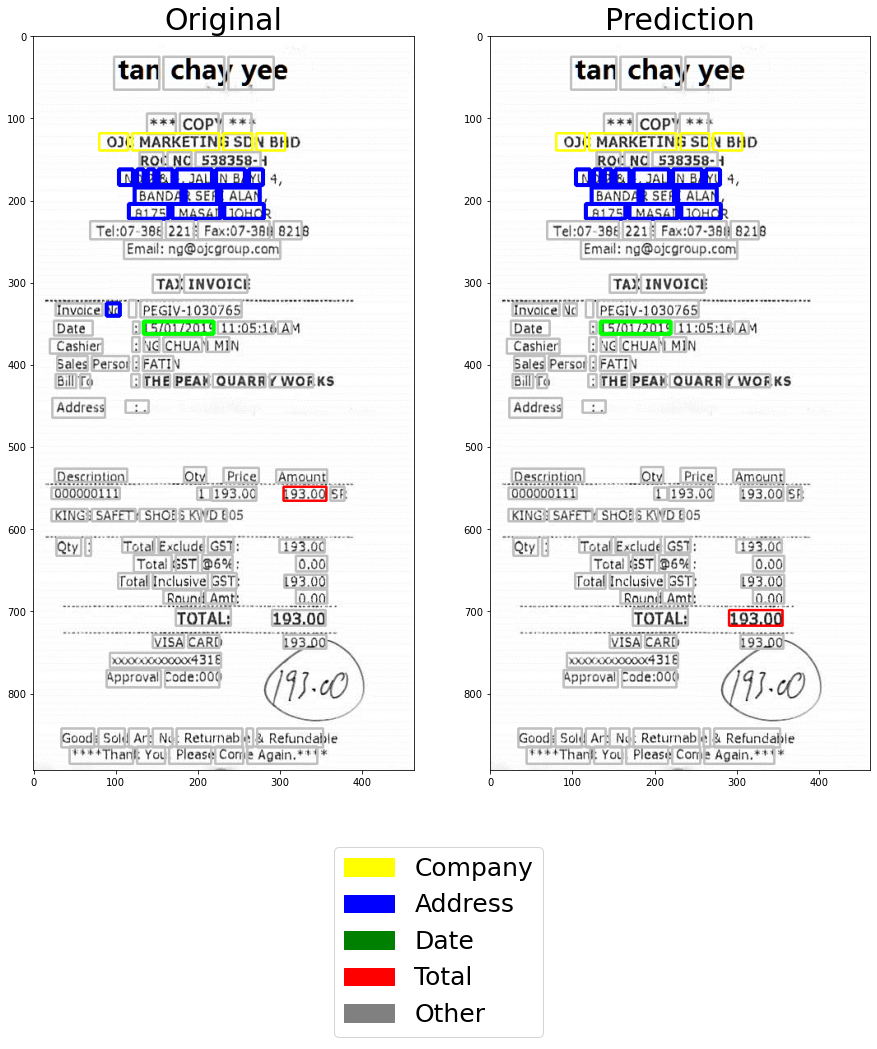

In [ ]:
display_prediction(merged_groups[0], 'test')

Filename: X51005444046.jpg


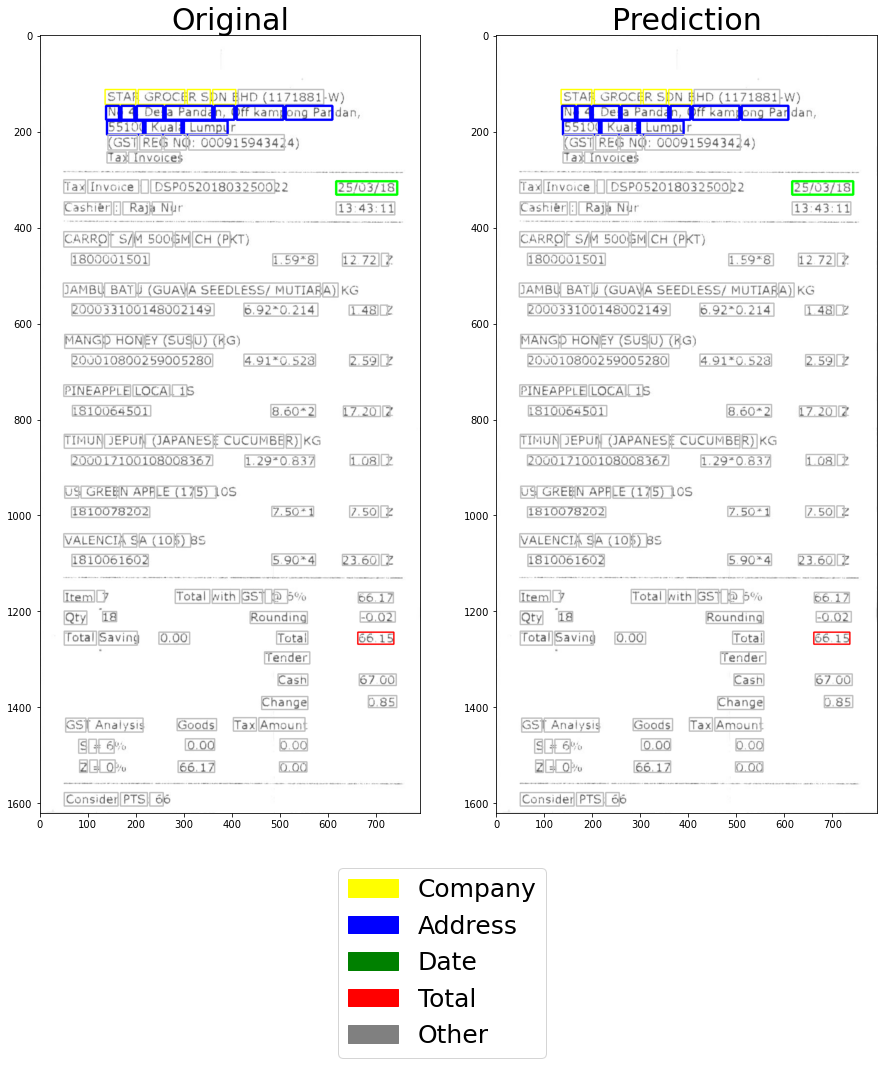

In [ ]:
display_prediction(merged_groups[34], 'test')